# 7.seq2seq

## 7.1 使用语言模型生成文本

In [3]:
#文本生成的实现
# coding: utf-8
import sys
sys.path.append('..')
import numpy as np
from common.functions import softmax
from ch06.rnnlm import Rnnlm
from ch06.better_rnnlm import BetterRnnlm


class RnnlmGen(Rnnlm):
    def generate(self, start_id, skip_ids=None, sample_size=100):
        word_ids = [start_id]

        x = start_id
        while len(word_ids) < sample_size:
            x = np.array(x).reshape(1, 1)
            score = self.predict(x)
            p = softmax(score.flatten())

            sampled = np.random.choice(len(p), size=1, p=p)
            if (skip_ids is None) or (sampled not in skip_ids):
                x = sampled
                word_ids.append(int(x))

        return word_ids

    def get_state(self):
        return self.lstm_layer.h, self.lstm_layer.c

    def set_state(self, state):
        self.lstm_layer.set_state(*state)


class BetterRnnlmGen(BetterRnnlm):
    def generate(self, start_id, skip_ids=None, sample_size=100):
        word_ids = [start_id]

        x = start_id
        while len(word_ids) < sample_size:
            x = np.array(x).reshape(1, 1)
            score = self.predict(x).flatten()
            p = softmax(score).flatten()

            sampled = np.random.choice(len(p), size=1, p=p)
            if (skip_ids is None) or (sampled not in skip_ids):
                x = sampled
                word_ids.append(int(x))

        return word_ids

    def get_state(self):
        states = []
        for layer in self.lstm_layers:
            states.append((layer.h, layer.c))
        return states

    def set_state(self, states):
        for layer, state in zip(self.lstm_layers, states):
            layer.set_state(*state)

In [9]:
# coding: utf-8
import sys
sys.path.append('..')
# from ch06.rnnlm_gen import RnnlmGen
from dataset import ptb


corpus, word_to_id, id_to_word = ptb.load_data('train')
vocab_size = len(word_to_id)
corpus_size = len(corpus)

model = RnnlmGen()
model.load_params('./ch06/Rnnlm.pkl')

# 设定start单词和skip单词
start_word = 'you'
start_id = word_to_id[start_word]
skip_words = ['N', '<unk>', '$']
skip_ids = [word_to_id[w] for w in skip_words]

# 文本生成
word_ids = model.generate(start_id, skip_ids)
txt = ' '.join([id_to_word[i] for i in word_ids])
txt = txt.replace(' <eos>', '.\n')
print(txt)


you 'd want to hear the risk going.
 while he is n't written to make that even there on u.s. opening to any securities on real estate investment in maker in location analysis.
 no one might like traditional while the cars will carry through any stock strategy when the move is taking out the contract market and unisys business are in hurricane and crucial hard free.
 analysts tried to build special improvement to the work facility from the book questioned costs like this.
 for the job mr. sagan came a imagine between rape and marriage of


In [14]:
# 更好的文本生成
# coding: utf-8
import sys
sys.path.append('..')
from common.np import *
# from rnnlm_gen import BetterRnnlmGen
from dataset import ptb


corpus, word_to_id, id_to_word = ptb.load_data('train')
vocab_size = len(word_to_id)
corpus_size = len(corpus)


model = BetterRnnlmGen()
model.load_params('./ch06/BetterRnnlm.pkl')

# 设定start字符和skip字符
start_word = 'you'
start_id = word_to_id[start_word]
skip_words = ['N', '<unk>', '$']
skip_ids = [word_to_id[w] for w in skip_words]
# 文本生成
word_ids = model.generate(start_id, skip_ids)
txt = ' '.join([id_to_word[i] for i in word_ids])
txt = txt.replace(' <eos>', '.\n')

print(txt)


model.reset_state()

start_words = 'the meaning of life is'
start_ids = [word_to_id[w] for w in start_words.split(' ')]

for x in start_ids[:-1]:
    x = np.array(x).reshape(1, 1)
    model.predict(x)

word_ids = model.generate(start_ids[-1], skip_ids)
word_ids = start_ids[:-1] + word_ids
txt = ' '.join([id_to_word[i] for i in word_ids])
txt = txt.replace(' <eos>', '.\n')
print('-' * 50)
print(txt)

OSError: No file: ./ch06/BetterRnnlm.pkl

## 7.2 seq2seq模型

In [15]:
# 加法数据集
# coding: utf-8
import sys
sys.path.append('..')
from dataset import sequence


(x_train, t_train), (x_test, t_test) = \
    sequence.load_data('addition.txt', seed=1984)
char_to_id, id_to_char = sequence.get_vocab()

print(x_train.shape, t_train.shape)
print(x_test.shape, t_test.shape)
# (45000, 7) (45000, 5)
# (5000, 7) (5000, 5)

print(x_train[0])
print(t_train[0])
# [ 3  0  2  0  0 11  5]
# [ 6  0 11  7  5]

print(''.join([id_to_char[c] for c in x_train[0]]))
print(''.join([id_to_char[c] for c in t_train[0]]))
# 71+118
# _189


(45000, 7) (45000, 5)
(5000, 7) (5000, 5)
[ 3  0  2  0  0 11  5]
[ 6  0 11  7  5]
71+118 
_189 


## 7.3 seq2seq的实现

In [18]:
# Encoder类
# coding: utf-8
import sys
sys.path.append('..')
from common.time_layers import *
from common.base_model import BaseModel


class Encoder:
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn

        embed_W = (rn(V, D) / 100).astype('f')
        lstm_Wx = (rn(D, 4 * H) / np.sqrt(D)).astype('f')
        lstm_Wh = (rn(H, 4 * H) / np.sqrt(H)).astype('f')
        lstm_b = np.zeros(4 * H).astype('f')

        self.embed = TimeEmbedding(embed_W)
        self.lstm = TimeLSTM(lstm_Wx, lstm_Wh, lstm_b, stateful=False)

        self.params = self.embed.params + self.lstm.params
        self.grads = self.embed.grads + self.lstm.grads
        self.hs = None

    def forward(self, xs):
        xs = self.embed.forward(xs)
        hs = self.lstm.forward(xs)
        self.hs = hs
        return hs[:, -1, :]

    def backward(self, dh):
        dhs = np.zeros_like(self.hs)
        dhs[:, -1, :] = dh

        dout = self.lstm.backward(dhs)
        dout = self.embed.backward(dout)
        return dout


class Decoder:
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn

        embed_W = (rn(V, D) / 100).astype('f')
        lstm_Wx = (rn(D, 4 * H) / np.sqrt(D)).astype('f')
        lstm_Wh = (rn(H, 4 * H) / np.sqrt(H)).astype('f')
        lstm_b = np.zeros(4 * H).astype('f')
        affine_W = (rn(H, V) / np.sqrt(H)).astype('f')
        affine_b = np.zeros(V).astype('f')

        self.embed = TimeEmbedding(embed_W)
        self.lstm = TimeLSTM(lstm_Wx, lstm_Wh, lstm_b, stateful=True)
        self.affine = TimeAffine(affine_W, affine_b)

        self.params, self.grads = [], []
        for layer in (self.embed, self.lstm, self.affine):
            self.params += layer.params
            self.grads += layer.grads

    def forward(self, xs, h):
        self.lstm.set_state(h)

        out = self.embed.forward(xs)
        out = self.lstm.forward(out)
        score = self.affine.forward(out)
        return score

    def backward(self, dscore):
        dout = self.affine.backward(dscore)
        dout = self.lstm.backward(dout)
        dout = self.embed.backward(dout)
        dh = self.lstm.dh
        return dh

    def generate(self, h, start_id, sample_size):
        sampled = []
        sample_id = start_id
        self.lstm.set_state(h)

        for _ in range(sample_size):
            x = np.array(sample_id).reshape((1, 1))
            out = self.embed.forward(x)
            out = self.lstm.forward(out)
            score = self.affine.forward(out)

            sample_id = np.argmax(score.flatten())
            sampled.append(int(sample_id))

        return sampled


class Seq2seq(BaseModel):
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        V, D, H = vocab_size, wordvec_size, hidden_size
        self.encoder = Encoder(V, D, H)
        self.decoder = Decoder(V, D, H)
        self.softmax = TimeSoftmaxWithLoss()

        self.params = self.encoder.params + self.decoder.params
        self.grads = self.encoder.grads + self.decoder.grads

    def forward(self, xs, ts):
        decoder_xs, decoder_ts = ts[:, :-1], ts[:, 1:]

        h = self.encoder.forward(xs)
        score = self.decoder.forward(decoder_xs, h)
        loss = self.softmax.forward(score, decoder_ts)
        return loss

    def backward(self, dout=1):
        dout = self.softmax.backward(dout)
        dh = self.decoder.backward(dout)
        dout = self.encoder.backward(dh)
        return dout

    def generate(self, xs, start_id, sample_size):
        h = self.encoder.forward(xs)
        sampled = self.decoder.generate(h, start_id, sample_size)
        return sampled


| epoch 1 |  iter 1 / 351 | time 0[s] | loss 2.56
| epoch 1 |  iter 21 / 351 | time 0[s] | loss 2.52
| epoch 1 |  iter 41 / 351 | time 1[s] | loss 2.17
| epoch 1 |  iter 61 / 351 | time 2[s] | loss 1.96
| epoch 1 |  iter 81 / 351 | time 3[s] | loss 1.91
| epoch 1 |  iter 101 / 351 | time 3[s] | loss 1.87
| epoch 1 |  iter 121 / 351 | time 4[s] | loss 1.86
| epoch 1 |  iter 141 / 351 | time 5[s] | loss 1.84
| epoch 1 |  iter 161 / 351 | time 6[s] | loss 1.80
| epoch 1 |  iter 181 / 351 | time 7[s] | loss 1.78
| epoch 1 |  iter 201 / 351 | time 7[s] | loss 1.77
| epoch 1 |  iter 221 / 351 | time 8[s] | loss 1.77
| epoch 1 |  iter 241 / 351 | time 9[s] | loss 1.76
| epoch 1 |  iter 261 / 351 | time 10[s] | loss 1.75
| epoch 1 |  iter 281 / 351 | time 11[s] | loss 1.74
| epoch 1 |  iter 301 / 351 | time 11[s] | loss 1.74
| epoch 1 |  iter 321 / 351 | time 12[s] | loss 1.74
| epoch 1 |  iter 341 / 351 | time 13[s] | loss 1.73
Q   58+77
T 162 
☒ 100 
---
Q 461+579
T 1139
☒ 1000
---
Q  48+285

| epoch 7 |  iter 121 / 351 | time 5[s] | loss 0.67
| epoch 7 |  iter 141 / 351 | time 6[s] | loss 0.67
| epoch 7 |  iter 161 / 351 | time 7[s] | loss 0.67
| epoch 7 |  iter 181 / 351 | time 7[s] | loss 0.66
| epoch 7 |  iter 201 / 351 | time 8[s] | loss 0.66
| epoch 7 |  iter 221 / 351 | time 9[s] | loss 0.66
| epoch 7 |  iter 241 / 351 | time 10[s] | loss 0.64
| epoch 7 |  iter 261 / 351 | time 11[s] | loss 0.65
| epoch 7 |  iter 281 / 351 | time 12[s] | loss 0.64
| epoch 7 |  iter 301 / 351 | time 13[s] | loss 0.63
| epoch 7 |  iter 321 / 351 | time 14[s] | loss 0.63
| epoch 7 |  iter 341 / 351 | time 14[s] | loss 0.62
Q   58+77
T 162 
☑ 162 
---
Q 461+579
T 1139
☒ 1142
---
Q  48+285
T 666 
☑ 666 
---
Q   551+8
T 163 
☒ 162 
---
Q  55+763
T 422 
☑ 422 
---
Q 752+006
T 857 
☒ 859 
---
Q 292+167
T 1053
☒ 1144
---
Q 795+038
T 1427
☒ 1431
---
Q  838+62
T 864 
☒ 866 
---
Q  39+341
T 236 
☒ 239 
---
val acc 17.500%
| epoch 8 |  iter 1 / 351 | time 0[s] | loss 0.66
| epoch 8 |  iter 21 / 3

| epoch 13 |  iter 201 / 351 | time 8[s] | loss 0.42
| epoch 13 |  iter 221 / 351 | time 9[s] | loss 0.43
| epoch 13 |  iter 241 / 351 | time 10[s] | loss 0.43
| epoch 13 |  iter 261 / 351 | time 10[s] | loss 0.41
| epoch 13 |  iter 281 / 351 | time 11[s] | loss 0.42
| epoch 13 |  iter 301 / 351 | time 12[s] | loss 0.41
| epoch 13 |  iter 321 / 351 | time 13[s] | loss 0.43
| epoch 13 |  iter 341 / 351 | time 14[s] | loss 0.40
Q   58+77
T 162 
☑ 162 
---
Q 461+579
T 1139
☒ 1140
---
Q  48+285
T 666 
☑ 666 
---
Q   551+8
T 163 
☒ 162 
---
Q  55+763
T 422 
☒ 424 
---
Q 752+006
T 857 
☒ 856 
---
Q 292+167
T 1053
☒ 1054
---
Q 795+038
T 1427
☒ 1429
---
Q  838+62
T 864 
☑ 864 
---
Q  39+341
T 236 
☒ 239 
---
val acc 39.420%
| epoch 14 |  iter 1 / 351 | time 0[s] | loss 0.41
| epoch 14 |  iter 21 / 351 | time 0[s] | loss 0.41
| epoch 14 |  iter 41 / 351 | time 1[s] | loss 0.41
| epoch 14 |  iter 61 / 351 | time 2[s] | loss 0.40
| epoch 14 |  iter 81 / 351 | time 3[s] | loss 0.40
| epoch 14 |  i

| epoch 19 |  iter 261 / 351 | time 11[s] | loss 0.33
| epoch 19 |  iter 281 / 351 | time 12[s] | loss 0.32
| epoch 19 |  iter 301 / 351 | time 13[s] | loss 0.32
| epoch 19 |  iter 321 / 351 | time 14[s] | loss 0.33
| epoch 19 |  iter 341 / 351 | time 14[s] | loss 0.33
Q   58+77
T 162 
☒ 161 
---
Q 461+579
T 1139
☒ 1140
---
Q  48+285
T 666 
☑ 666 
---
Q   551+8
T 163 
☑ 163 
---
Q  55+763
T 422 
☑ 422 
---
Q 752+006
T 857 
☒ 858 
---
Q 292+167
T 1053
☒ 1052
---
Q 795+038
T 1427
☒ 1430
---
Q  838+62
T 864 
☑ 864 
---
Q  39+341
T 236 
☒ 238 
---
val acc 47.540%
| epoch 20 |  iter 1 / 351 | time 0[s] | loss 0.32
| epoch 20 |  iter 21 / 351 | time 0[s] | loss 0.35
| epoch 20 |  iter 41 / 351 | time 1[s] | loss 0.33
| epoch 20 |  iter 61 / 351 | time 2[s] | loss 0.33
| epoch 20 |  iter 81 / 351 | time 3[s] | loss 0.31
| epoch 20 |  iter 101 / 351 | time 4[s] | loss 0.31
| epoch 20 |  iter 121 / 351 | time 5[s] | loss 0.33
| epoch 20 |  iter 141 / 351 | time 6[s] | loss 0.32
| epoch 20 |  it

| epoch 25 |  iter 321 / 351 | time 13[s] | loss 0.28
| epoch 25 |  iter 341 / 351 | time 14[s] | loss 0.28
Q   58+77
T 162 
☑ 162 
---
Q 461+579
T 1139
☒ 1140
---
Q  48+285
T 666 
☑ 666 
---
Q   551+8
T 163 
☑ 163 
---
Q  55+763
T 422 
☑ 422 
---
Q 752+006
T 857 
☒ 856 
---
Q 292+167
T 1053
☒ 1052
---
Q 795+038
T 1427
☒ 1426
---
Q  838+62
T 864 
☑ 864 
---
Q  39+341
T 236 
☑ 236 
---
val acc 54.120%


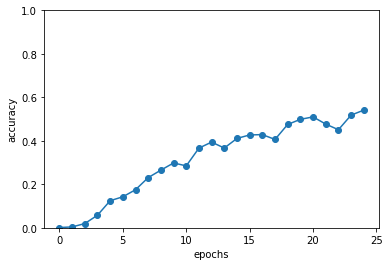

In [22]:
# coding: utf-8
import sys
sys.path.append('..')
import numpy as np
import matplotlib.pyplot as plt
from dataset import sequence
from common.optimizer import Adam
from common.trainer import Trainer
from common.util import eval_seq2seq
# from seq2seq import Seq2seq
from ch07.peeky_seq2seq import PeekySeq2seq


# 读入数据集
(x_train, t_train), (x_test, t_test) = sequence.load_data('addition.txt')
x_train, x_test = x_train[:,::-1], x_test[:,::-1]
char_to_id, id_to_char = sequence.get_vocab()

# Reverse input? =================================================
is_reverse = False  # True
if is_reverse:
    x_train, x_test = x_train[:, ::-1], x_test[:, ::-1]
# ================================================================

# 设定超参数
vocab_size = len(char_to_id)
wordvec_size = 16
hidden_size = 128
batch_size = 128
max_epoch = 25
max_grad = 5.0

# Normal or Peeky? ==============================================
model = Seq2seq(vocab_size, wordvec_size, hidden_size)
# model = PeekySeq2seq(vocab_size, wordvec_size, hidden_size)
# ================================================================
optimizer = Adam()
trainer = Trainer(model, optimizer)

acc_list = []
for epoch in range(max_epoch):
    trainer.fit(x_train, t_train, max_epoch=1,
                batch_size=batch_size, max_grad=max_grad)

    correct_num = 0
    for i in range(len(x_test)):
        question, correct = x_test[[i]], t_test[[i]]
        verbose = i < 10
        correct_num += eval_seq2seq(model, question, correct,
                                    id_to_char, verbose, is_reverse)

    acc = float(correct_num) / len(x_test)
    acc_list.append(acc)
    print('val acc %.3f%%' % (acc * 100))

# 绘制图形
x = np.arange(len(acc_list))
plt.plot(x, acc_list, marker='o')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.ylim(0, 1.0)
plt.show()



## 7.4 seq2seq的改进

In [23]:
## 反转输入数据（reverse）
## 信息泄漏（Peeky）
# coding: utf-8
import sys
sys.path.append('..')
from common.time_layers import *
from ch07.seq2seq import Seq2seq, Encoder


class PeekyDecoder:
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn

        embed_W = (rn(V, D) / 100).astype('f')
        lstm_Wx = (rn(H + D, 4 * H) / np.sqrt(H + D)).astype('f')
        lstm_Wh = (rn(H, 4 * H) / np.sqrt(H)).astype('f')
        lstm_b = np.zeros(4 * H).astype('f')
        affine_W = (rn(H + H, V) / np.sqrt(H + H)).astype('f')
        affine_b = np.zeros(V).astype('f')

        self.embed = TimeEmbedding(embed_W)
        self.lstm = TimeLSTM(lstm_Wx, lstm_Wh, lstm_b, stateful=True)
        self.affine = TimeAffine(affine_W, affine_b)

        self.params, self.grads = [], []
        for layer in (self.embed, self.lstm, self.affine):
            self.params += layer.params
            self.grads += layer.grads
        self.cache = None

    def forward(self, xs, h):
        N, T = xs.shape
        N, H = h.shape

        self.lstm.set_state(h)

        out = self.embed.forward(xs)
        hs = np.repeat(h, T, axis=0).reshape(N, T, H)
        out = np.concatenate((hs, out), axis=2)

        out = self.lstm.forward(out)
        out = np.concatenate((hs, out), axis=2)

        score = self.affine.forward(out)
        self.cache = H
        return score

    def backward(self, dscore):
        H = self.cache

        dout = self.affine.backward(dscore)
        dout, dhs0 = dout[:, :, H:], dout[:, :, :H]
        dout = self.lstm.backward(dout)
        dembed, dhs1 = dout[:, :, H:], dout[:, :, :H]
        self.embed.backward(dembed)

        dhs = dhs0 + dhs1
        dh = self.lstm.dh + np.sum(dhs, axis=1)
        return dh

    def generate(self, h, start_id, sample_size):
        sampled = []
        char_id = start_id
        self.lstm.set_state(h)

        H = h.shape[1]
        peeky_h = h.reshape(1, 1, H)
        for _ in range(sample_size):
            x = np.array([char_id]).reshape((1, 1))
            out = self.embed.forward(x)

            out = np.concatenate((peeky_h, out), axis=2)
            out = self.lstm.forward(out)
            out = np.concatenate((peeky_h, out), axis=2)
            score = self.affine.forward(out)

            char_id = np.argmax(score.flatten())
            sampled.append(char_id)

        return sampled


class PeekySeq2seq(Seq2seq):
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        V, D, H = vocab_size, wordvec_size, hidden_size
        self.encoder = Encoder(V, D, H)
        self.decoder = PeekyDecoder(V, D, H)
        self.softmax = TimeSoftmaxWithLoss()

        self.params = self.encoder.params + self.decoder.params
        self.grads = self.encoder.grads + self.decoder.grads


## 7.5 seq2seq的应用

In [ ]:
# seq2seq的应用
1.聊天机器人
2.算法学习
3.自动图像描述